In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#Data load. No changes here

#https://datos.gob.es/es/catalogo/a09002970-municipios-de-espana
# We will instead be using names of villages/cities in Spain. Only 8k data
import pandas as pd

# Read the CSV data
df = pd.read_csv("Municipis_d_Espanya.csv", sep=",")

# Function to clean the names
def clean_name(name):
    # If there's a slash, take the first part
    name = name.split('/')[0]
    # If it's in "Last, First" format, swap it to "First Last"
    if ',' in name:
        parts = name.split(', ')
        if len(parts) == 2:
            name = f"{parts[1]} {parts[0]}"
    return name

# Apply the function to clean names
df["Nom"] = df["Nom"].apply(clean_name)

# Extract only the 'Territorio' column as a list
words = df["Nom"].tolist()

print(f"{len(words)} words")

#Simplifying the problem (lowercase and no accents)
import unidecode
import re

print(words[:1])
words = [re.sub(r'[\(\)\'"]', '', unidecode.unidecode(word).lower()) for word in words]
print(words[:1])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

8134 words
['Alegría-Dulantzi']
['alegria-dulantzi']
{1: ' ', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}
29
torch.Size([85032, 3]) torch.Size([85032])
torch.Size([10606, 3]) torch.Size([10606])
torch.Size([10768, 3]) torch.Size([10768])


# Pytorching goes brrrr

We will develop modules with the style of pytorch

In [2]:
# These classes implement the same API as nn.Module in PyTorch

class Linear:
    """Simple Linear layer implementation (y = wx + b)"""
    def __init__(self, fan_in, fan_out, bias=True):
        # Initialize weights using Kaiming initialization (scaled by fan_in)
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        # Forward pass: matrix multiplication (and bias addition if present)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # Return trainable parameters
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    """Batch Normalization layer for stabilizing training"""
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps  # Small constant for avoid /0
        self.momentum = momentum  # For running statistics update
        self.training = True
        # Learnable parameters
        self.gamma = torch.ones(dim)   # Scale parameter
        self.beta = torch.zeros(dim)   # Shift parameter
        # Running statistics for inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            # During training: use batch statistics
            xmean = x.mean(0, keepdim=True)  # Batch mean
            xvar = x.var(0, keepdim=True)    # Batch variance
            
            # Update running statistics for inference
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            # During inference: use running statistics
            xmean = self.running_mean
            xvar = self.running_var
        
        # Normalize and apply learnable parameters
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta          # Scale and shift
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    """Hyperbolic tangent activation function"""
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []  # No trainable parameters

In [3]:
# Model architecture parameters
n_embd = 10      # Dimension of character embeddings
n_hidden = 300   # Number of neurons in hidden layers
g = torch.Generator().manual_seed(2147483647)  # For reproducibility

# Initialize embedding matrix
C = torch.randn((vocab_size, n_embd), generator=g)

# Define network architecture with BatchNorm
# Each Linear->BatchNorm->Tanh block forms a normalized pre-activation residual unit
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# Alternative architecture without BatchNorm (commented out)
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
    # Scale down the last layer to make initial predictions less confident
    layers[-1].gamma *= 0.1
    
    # Option to scale other layers (commented out)
    for layer in layers[:-1]:
         if isinstance(layer, Linear):
             layer.weight *= 5/3

# Collect all trainable parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # Total number of parameters

# Enable gradient computation for all parameters
for p in parameters:
    p.requires_grad = True

381048


In [4]:
# Training hyperparameters
max_steps = 200000
batch_size = 64
lossi = []  # Store loss history (log10)
ud = []     # Store update/data ratio history (log10)

for i in range(max_steps):
    
    # Create minibatch by random sampling
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch of inputs and targets
    
    # Forward pass--->
    emb = C[Xb]  # Transform characters into embedding vectors
    x = emb.view(emb.shape[0], -1)  # Flatten the embeddings for the linear layer
    for layer in layers:
        x = layer(x)  # Pass through each layer sequentially
    loss = F.cross_entropy(x, Yb)  # Calculate cross entropy loss
    
    # Backward pass<----
    #for layer in layers:
    #    layer.out.retain_grad()# Keep gradients of intermediate activations for debugging
    
    # Zero all parameter gradients
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Parameter update with learning rate decay
    lr = 0.1 #if i < 150000 else 0.01  # Reduce learning rate after 150k steps. Commenting this after bad results
    for p in parameters:
        p.data += -lr * p.grad  # Simple SGD update
    
    # Monitoring and logging
    if i % 5000 == 0:  # Print progress every 5k steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Store loss in log scale
    lossi.append(loss.log10().item())
    
    # Calculate and store update-to-data ratio for each parameter
    # This helps monitor the relative scale of updates compared to parameter values
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    #if i>1000:
    #    break

      0/ 200000: 3.3724
   5000/ 200000: 1.9283
  10000/ 200000: 1.9747
  15000/ 200000: 2.0425
  20000/ 200000: 1.4162
  25000/ 200000: 2.0987
  30000/ 200000: 1.9928
  35000/ 200000: 1.9282
  40000/ 200000: 1.5294
  45000/ 200000: 1.4798
  50000/ 200000: 1.6461
  55000/ 200000: 1.6548
  60000/ 200000: 1.7600
  65000/ 200000: 1.7398
  70000/ 200000: 1.5471
  75000/ 200000: 1.5093
  80000/ 200000: 1.3402
  85000/ 200000: 1.7992
  90000/ 200000: 1.2533
  95000/ 200000: 1.5201
 100000/ 200000: 1.7021
 105000/ 200000: 1.5949
 110000/ 200000: 1.4722
 115000/ 200000: 1.4421
 120000/ 200000: 1.8737
 125000/ 200000: 1.6128
 130000/ 200000: 1.6220
 135000/ 200000: 1.3093
 140000/ 200000: 1.4513
 145000/ 200000: 1.3342
 150000/ 200000: 1.5065
 155000/ 200000: 1.8027
 160000/ 200000: 1.5214
 165000/ 200000: 1.2896
 170000/ 200000: 1.1586
 175000/ 200000: 1.3708
 180000/ 200000: 1.3738
 185000/ 200000: 1.5811
 190000/ 200000: 1.3973
 195000/ 200000: 1.6385


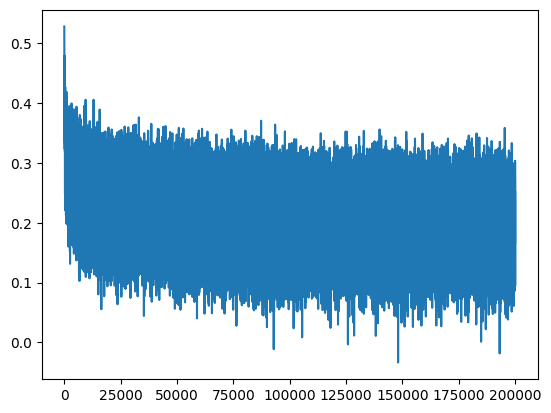

In [5]:
plt.plot(lossi)

# Diagnostic Tools

layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.06%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 3.09%
layer 8 (      Tanh): mean +0.00, std 0.63, saturated: 2.99%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 3.10%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 2.85%


Text(0.5, 1.0, 'activation distribution')

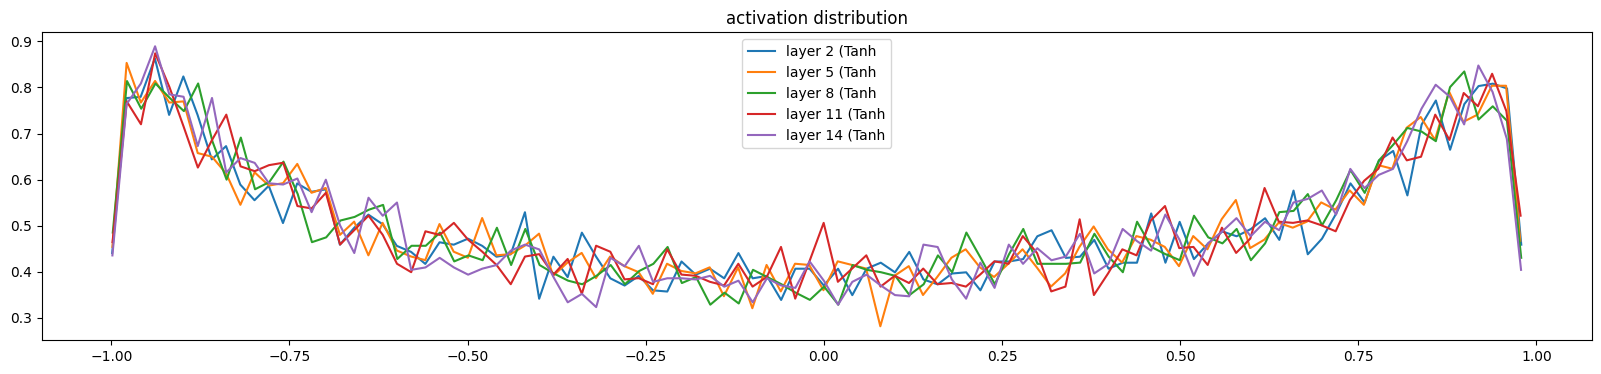

In [ ]:
#Only first step

plt.figure(figsize=(20, 4))  # width=20, height=4
legends = []

# Analyze all layers except the output layer
for i, layer in enumerate(layers[:-1]):
    # Only analyze Tanh activation layers
    if isinstance(layer, Tanh):
        t = layer.out  # Get layer activations
        
        # Print statistics for each Tanh layer:
        # Expected output for a well-behaved network:
        # - mean: should be close to 0 (between -0.1 and 0.1)
        # - std: should be around 0.5-0.8 for good gradient flow
        # - saturation: ideally less than 5-10% of neurons should be saturated
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % 
              (i, layer.__class__.__name__, 
               t.mean(), 
               t.std(), 
               (t.abs() > 0.97).float().mean()*100))
        
        # Create histogram of activations
        # Expected: Bell-shaped distribution centered around 0
        # - Should NOT be too peaked (indicates underutilization)
        # - Should NOT be too flat (indicates poor learning)
        # - Should NOT have large spikes at -1 or 1 (indicates saturation)
        hy, hx = torch.histogram(t, density=True)  # density=True for probability density
        plt.plot(hx[:-1].detach(), hy.detach())  # Plot histogram
        legends.append(f'layer {i} ({layer.__class__.__name__}')

# Add plot details
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 6.980228e-04
layer 5 (      Tanh): mean +0.000000, std 6.074199e-04
layer 8 (      Tanh): mean -0.000000, std 5.887804e-04
layer 11 (      Tanh): mean -0.000000, std 5.676620e-04
layer 14 (      Tanh): mean +0.000000, std 5.605191e-04


Text(0.5, 1.0, 'gradient distribution')

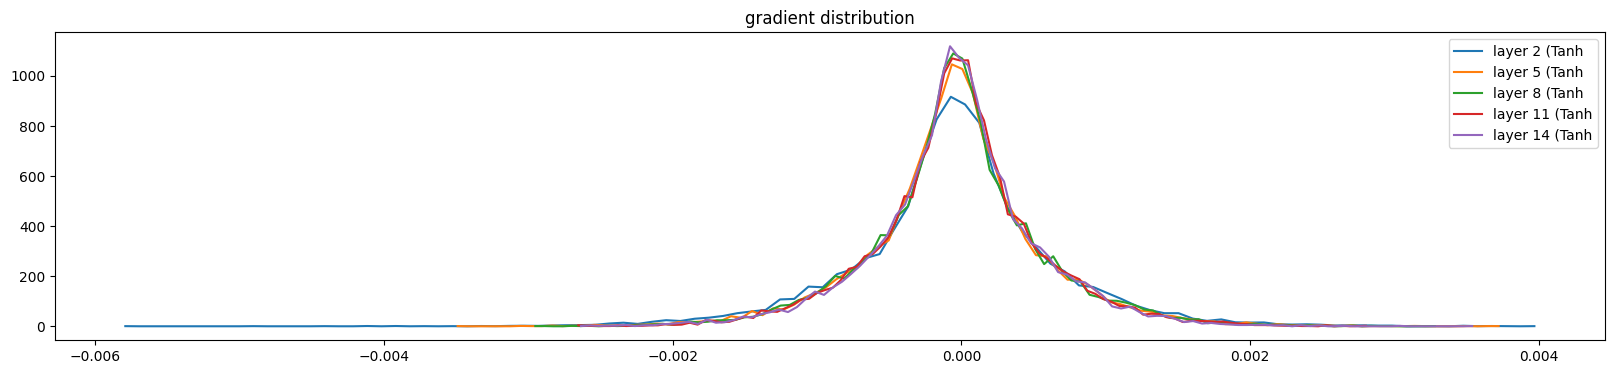

In [ ]:
#Only first step


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad

    # Print gradient statistics for each Tanh layer
    # Expected for well-behaved backpropagation:
    # - mean: should be very close to 0 (typically in range 1e-6 to 1e-8)
    # - std: should be consistent across layers (no vanishing/exploding)
    print('layer %d (%10s): mean %+f, std %e' %(i, layer.__class__.__name__,t.mean(),t.std()))  # Monitor for gradient scaling issues
    
    # Create histogram of gradients
    # Expected distribution:
    # - Should be symmetric around 0
    # - Should have similar scale across layers
    # - Should not have extreme outliers
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
    
plt.legend(legends);
plt.title('gradient distribution')


# The final plot should show:
# 1. Similar gradient distributions across layers
# 2. No signs of vanishing gradients (distributions collapsing to 0)
# 3. No signs of exploding gradients (very wide or scattered distributions)
# 4. Roughly symmetric distributions around 0

weight   (29, 10) | mean +0.000000 | std 6.041232e-03 | grad:data ratio 6.001924e-03
weight  (30, 300) | mean +0.000018 | std 3.923575e-03 | grad:data ratio 2.114493e-02
weight (300, 300) | mean +0.000001 | std 2.643203e-03 | grad:data ratio 4.387274e-02
weight (300, 300) | mean -0.000002 | std 2.451971e-03 | grad:data ratio 4.106025e-02
weight (300, 300) | mean +0.000007 | std 2.368972e-03 | grad:data ratio 3.984848e-02
weight (300, 300) | mean -0.000001 | std 2.281855e-03 | grad:data ratio 3.860466e-02
weight  (300, 29) | mean +0.000034 | std 8.076292e-03 | grad:data ratio 1.153472e-01


Text(0.5, 1.0, 'weights gradient distribution')

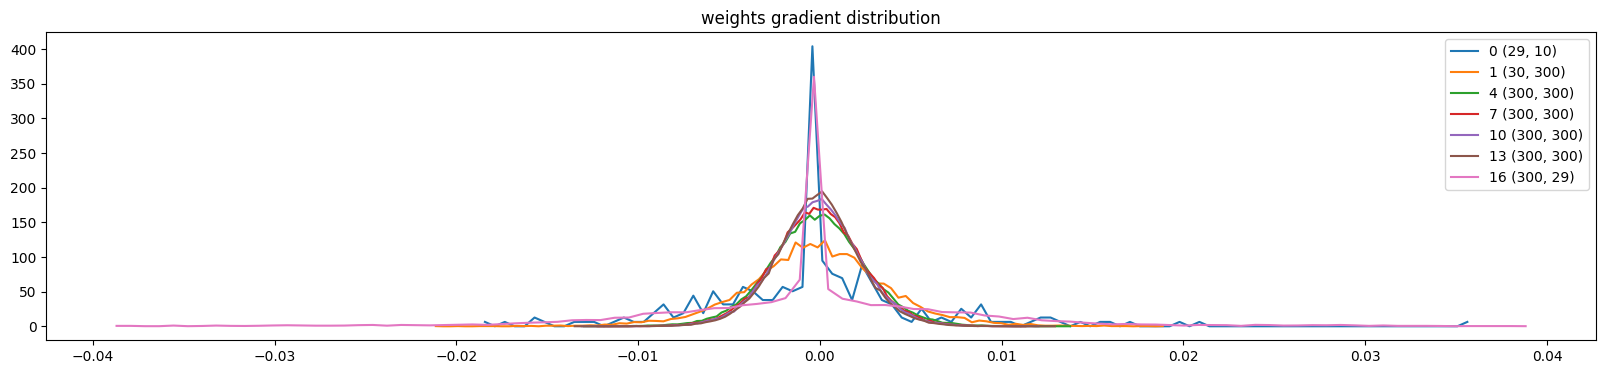

In [ ]:
# Visualize gradient distributions for model parameters (weights)
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []

# Analyze gradients for each parameter tensor
for i, p in enumerate(parameters):
   t = p.grad  # Get gradients
   
   # Only analyze 2D tensors (weight matrices, not biases)
   if p.ndim == 2:
       # Print key statistics for gradient health monitoring:
       # - shape: dimensions of weight matrix
       # - mean: should be close to 0
       # - std: monitor for exploding/vanishing
       # - grad:data ratio: key indicator of update scale. scale of the gradient vs scale of the values
       #   (typically should be between 1e-3 and 1e-4 for stable training)
       print('weight %10s | mean %+f | std %e | grad:data ratio %e' % 
             (tuple(p.shape),    # Shape of weight matrix
              t.mean(),          # Mean should be ~0
              t.std(),           # Gradient magnitude
              t.std() / p.std()) # Relative scale of updates
       )
       
       # Create histogram of gradients
       # Expected:
       # - Bell-shaped distribution centered at 0
       # - Similar scales across layers (if using BatchNorm)
       # - No extreme outliers
       hy, hx = torch.histogram(t, density=True)
       plt.plot(hx[:-1].detach(), hy.detach())
       legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution')

# The plot should show:
# 1. Similar gradient distributions across layers
# 2. All distributions centered around 0
# 3. Reasonable scales (not too large/small)
# 4. grad:data ratios around 1e-3 to 1e-4 for stable training
# 5. No evidence of vanishing (very small std) or exploding (very large std) gradients

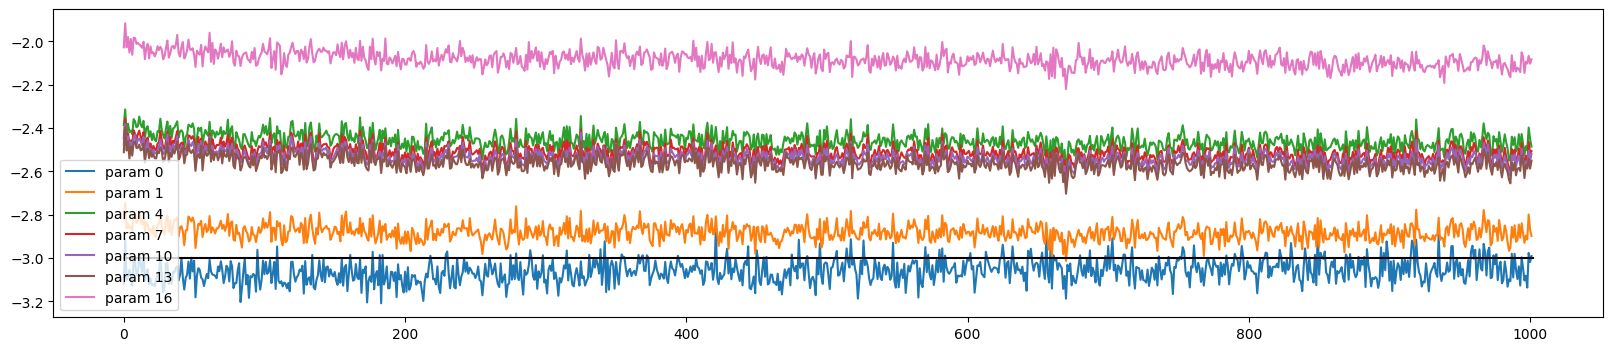

In [22]:
#1000 STEPS

#ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

# ud stores the evolution of the learning rate-scaled gradient-to-data ratio for each parameter over training steps.
# Each entry in ud corresponds to a training step and contains a list of log10-scaled ratios for all parameters.
# This ratio measures how significant the parameter updates are relative to the parameter values.
# If the ratio is too small (e.g., below -3 in log10 scale), training may be progressing too slowly.


plt.figure(figsize=(20, 4))  # Create a wide figure to clearly visualize the curves
legends = []  # List to store legends for each curve

for i, p in enumerate(parameters):  # Iterate over each parameter
    if p.ndim == 2:  # If the parameter is a 2D array
        plt.plot([ud[j][i] for j in range(len(ud))])  # Plot its evolution over time
        legends.append('param %d' % i)  # Add its label to the legend

# Draw a horizontal reference line at y = -3 to indicate a key threshold in the plot
plt.plot([0, len(ud)], [-3, -3], 'k')  # These ratios should be around ~1e-3

#if its below, parameters are no training fast enough

plt.legend(legends)  # Display the legend to identify each curve


In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.5273252725601196
val 1.8310195207595825


In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


santillanueva de arroyo.
los.
santzamariegordo.
san de sobrejo de la bagepero.
villanucillo.
rendetrevicid.
caste.
navaque.
fuenco.
ampo.
tocina.
villos del rios.
villalutxens.
fondad de volberzobledo.
gar.
chuelo.
riba.
pillo.
sant cueva.
villaharias.
luquente.
aranes.
santudel redon.
santan.
fontorresno de fonte de losa.
nabanada.
quironcepcion.
campolacindel riojas.
la sierva.
sal.
mora.
abuente ebro.
zeatcadas.
casarite don.
torres.
fres de sierrera.
sant matute.
la de albillar del prio.
pedronuevo bajo.
albarroyor del genitosobre.
tabelves.
prador.
sorihuera del riberladorontenete.
rubios bla cubio de arra de torriller.
higuerogeces.
segas.
merita cerva.
azuelo.
juelos guimendorros.
santa cruz de rodillonanada.
